# 🌊 **Water Segmentation using Multispectral Data**

The goal of this project is to **develop a robust model for extracting water bodies** from satellite multispectral imagery.  
Accurate water segmentation is important for monitoring water resources, flood management, and environmental protection.  

We will experiment with two main approaches:  
1. **Model 1**: Using all available spectral bands.  
2. **Model 2**: Using selected spectral bands (SWIR1, SWIR2, NIR).  

Finally, we will compare model performance using metrics such as **IoU, F1-Score, Precision, and Recall**,  
and visualize sample predictions against ground truth masks.

In [3]:
import os
import zipfile
import random
from PIL import Image
import cv2
import tifffile as tiff
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, BinaryIoU
from keras.callbacks import EarlyStopping

os.environ['SM_FRAMEWORK'] = 'tf.keras'
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


## **Data Preparation**
- Extract dataset from ZIP
- Load images & masks
- Prepare directories

In [4]:
zip_path = '/content/satalite data.zip'
path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path)

dataset_path = '/content/data'
dataset_dir = os.listdir(dataset_path)

In [5]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

mask_dir = dataset_path + '/labels'
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# **Data Normalization (Per-Channel Normalization)**

In [6]:
def standardize_image(image):
    image = np.transpose(image, (2, 0, 1))

    normalized_image = np.zeros_like(image, dtype=np.float32)

    num_channels = image.shape[0]
    for i in range(num_channels):
        band = image[i]
        mean = np.mean(band)
        std = np.std(band)

        if std > 0:
            normalized_image[i] = (band - mean) / std
        else:
            normalized_image[i] = band

    return normalized_image

normalized_images = [standardize_image(img) for img in images]

In [7]:
normalized_images[0].shape

(12, 128, 128)

## **Data Splitting**
- Convert to NumPy arrays
- Expand mask dimensions
- Train/Test split

In [8]:
X = np.array(normalized_images, dtype=np.float32)
y = np.array(masks, dtype=np.float32)
y = np.expand_dims(y, axis=-1)

X = np.transpose(X, (0, 2, 3, 1))

print("X shape after transpose:", X.shape)
print("y shape:", y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

X shape after transpose: (306, 128, 128, 12)
y shape: (306, 128, 128, 1)
Train: (244, 128, 128, 12) (244, 128, 128, 1)
Test: (62, 128, 128, 12) (62, 128, 128, 1)


## **Model Architecture**
- U-Net with ResNet34 backbone
- Input shape: (128, 128, 12)

In [9]:
import segmentation_models as sm
import tensorflow as tf

loss_fn = sm.losses.DiceLoss()

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.Precision(threshold=0.5),
    sm.metrics.Recall(threshold=0.5),
    sm.metrics.FScore(threshold=0.5)
]


unet_resnet34 = sm.Unet(
    backbone_name="resnet34",
    input_shape=(128, 128, 12),
    encoder_weights=None,
    classes=1,
    activation="sigmoid"
)

unet_resnet34.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=metrics
)

unet_resnet34.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,484,405 (93.40 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

## **Model Training**
- Loss: Dice Loss
- Metrics: IOU, Precision, Recall, F1-Score

In [10]:
history = unet_resnet34.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=100,
    verbose=1
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - f1-score: 0.4080 - iou_score: 0.2609 - loss: 0.6268 - precision: 0.2897 - recall: 0.7296 - val_f1-score: 0.0160 - val_iou_score: 0.0081 - val_loss: 0.9838 - val_precision: 0.2440 - val_recall: 0.0083
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - f1-score: 0.5529 - iou_score: 0.3973 - loss: 0.5153 - precision: 0.4303 - recall: 0.8609 - val_f1-score: 0.0250 - val_iou_score: 0.0127 - val_loss: 0.9720 - val_precision: 0.2790 - val_recall: 0.0131
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - f1-score: 0.5721 - iou_score: 0.4350 - loss: 0.5194 - precision: 0.4704 - recall: 0.9138 - val_f1-score: 0.0335 - val_iou_score: 0.0171 - val_loss: 0.9370 - val_precision: 0.3251 - val_recall: 0.0177
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - f1-score: 0.6700 - iou_score: 0.5208 - loss: 0.4408 - precision: 0.5568 - recall: 0.9192 - val_f1-score: 0.1953 - val_iou_score: 0.1257 - val_loss: 0.7421 - val_precision: 0.5828 - val_

In [11]:
results = unet_resnet34.evaluate(X_test, y_test, verbose=1)
print("Test Results:")
for name, val in zip(unet_resnet34.metrics_names, results):
    print(f"{name}: {val:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - f1-score: 0.8748 - iou_score: 0.7791 - loss: 0.1271 - precision: 0.9249 - recall: 0.8318
Test Results:
loss: 0.1389
compile_metrics: 0.7599


## **Model 2: U-Net (ResNet34) using Selected Bands**
- Input bands: SWIR1, SWIR2, NIR
- Input shape: (128, 128, 3)
- Loss: Dice Loss
- Metrics: IOU, Precision, Recall, F1-Score

In [12]:
X_sw1_sw2_nir = X[:, :, :, [4, 5, 6]]

print("X_selected shape:", X_sw1_sw2_nir.shape)

X_selected shape: (306, 128, 128, 3)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sw1_sw2_nir, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (244, 128, 128, 3) (244, 128, 128, 1)
Test: (62, 128, 128, 3) (62, 128, 128, 1)


In [14]:
import segmentation_models as sm
from tensorflow.keras import optimizers

unet_resnet34 = sm.Unet(
    backbone_name="resnet34",
    encoder_weights="imagenet",
    input_shape=(128, 128, 3),
    classes=1,
    activation="sigmoid"
)

dice_loss = sm.losses.DiceLoss()

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    sm.metrics.Precision(threshold=0.5),
    sm.metrics.Recall(threshold=0.5)
]

unet_resnet34.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=metrics
)

unet_resnet34.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_34   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_3… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_37   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath="unet_resnet34_3bands_best.h5",
        monitor="val_iou_score",
        mode="max",
        save_best_only=True,
        verbose=1
    )
]

In [16]:
history = unet_resnet34.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - f1-score: 0.3868 - iou_score: 0.2453 - loss: 0.6156 - precision: 0.2487 - recall: 0.9546
Epoch 1: val_iou_score improved from -inf to 0.23002, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 894ms/step - f1-score: 0.3880 - iou_score: 0.2464 - loss: 0.6144 - precision: 0.2498 - recall: 0.9546 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6555 - val_precision: 0.2300 - val_recall: 0.9996 - learning_rate: 1.0000e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.4489 - iou_score: 0.2983 - loss: 0.5384 - precision: 0.3026 - recall: 0.9591
Epoch 2: val_iou_score improved from 0.23002 to 0.23002, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - f1-score: 0.4505 - iou_score: 0.2998 - loss: 0.5376 - precision: 0.3043 - recall: 0.9585 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6419 - val_precision: 0.2300 - val_recall: 0.9997 - learning_rate: 1.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.6383 - iou_score: 0.4871 - loss: 0.5037 - precision: 0.5033 - recall: 0.9490
Epoch 3: val_iou_score did not improve from 0.23002
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - f1-score: 0.6398 - iou_score: 0.4887 - loss: 0.5028 - precision: 0.5052 - recall: 0.9487 - val_f1-score: 0.3680 - val_iou_score: 0.2300 - val_loss: 0.6401 - val_precision: 0.2300 - val_recall: 0.9998 - learning_rate: 1.0000e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.6919 - iou_score: 0.5565 - loss: 0.4811 - precision: 0.5803 - recall: 0.9422
Epoch 4: val_iou_score improved from 0.23002 to 0.23003, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - f1-score: 0.6928 - iou_score: 0.5575 - loss: 0.4803 - precision: 0.5813 - recall: 0.9420 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6388 - val_precision: 0.2300 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.7288 - iou_score: 0.5823 - loss: 0.4511 - precision: 0.6087 - recall: 0.9389
Epoch 5: val_iou_score did not improve from 0.23003
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.7294 - iou_score: 0.5831 - loss: 0.4504 - precision: 0.6096 - recall: 0.9390 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6382 - val_precision: 0.2300 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.7480 - iou_score: 0.6151 - loss: 0.4213 - precision: 0.6395 - recall: 0.9525
Epoch 6: val_iou_score did not improve from 0.23003
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - f1-score: 0.7482 - iou_sco

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - f1-score: 0.7625 - iou_score: 0.6330 - loss: 0.3943 - precision: 0.6617 - recall: 0.9506 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6359 - val_precision: 0.2300 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.7556 - iou_score: 0.6256 - loss: 0.3959 - precision: 0.6420 - recall: 0.9688
Epoch 9: val_iou_score improved from 0.23003 to 0.23029, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - f1-score: 0.7567 - iou_score: 0.6268 - loss: 0.3947 - precision: 0.6434 - recall: 0.9686 - val_f1-score: 0.3684 - val_iou_score: 0.2303 - val_loss: 0.6359 - val_precision: 0.2303 - val_recall: 0.9999 - learning_rate: 1.0000e-04
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - f1-score: 0.7895 - iou_score: 0.6739 - loss: 0.3502 - precision: 0.6923 - recall: 0.9657
Epoch 10: val_iou_score did not improve from 0.23029
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - f1-score: 0.7892 - iou_score: 0.6737 - loss: 0.3503 - precision: 0.6921 - recall: 0.9657 - val_f1-score: 0.3681 - val_iou_score: 0.2301 - val_loss: 0.6378 - val_precision: 0.2301 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.8183 - iou_score: 0.7101 - loss: 0.3149 - precision: 0.7305 - recall: 0.9660
Epoch 11: val_iou_score improved from 0.23029 to 0.23198, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - f1-score: 0.8175 - iou_score: 0.7091 - loss: 0.3157 - precision: 0.7295 - recall: 0.9660 - val_f1-score: 0.3706 - val_iou_score: 0.2320 - val_loss: 0.6338 - val_precision: 0.2320 - val_recall: 0.9986 - learning_rate: 1.0000e-04
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.8212 - iou_score: 0.7040 - loss: 0.3133 - precision: 0.7382 - recall: 0.9450
Epoch 12: val_iou_score improved from 0.23198 to 0.23277, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - f1-score: 0.8212 - iou_score: 0.7041 - loss: 0.3136 - precision: 0.7380 - recall: 0.9454 - val_f1-score: 0.3716 - val_iou_score: 0.2328 - val_loss: 0.6337 - val_precision: 0.2332 - val_recall: 0.9908 - learning_rate: 1.0000e-04
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - f1-score: 0.8254 - iou_score: 0.7138 - loss: 0.3153 - precision: 0.7327 - recall: 0.9645
Epoch 13: val_iou_score improved from 0.23277 to 0.23578, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - f1-score: 0.8254 - iou_score: 0.7138 - loss: 0.3150 - precision: 0.7328 - recall: 0.9644 - val_f1-score: 0.3756 - val_iou_score: 0.2358 - val_loss: 0.6295 - val_precision: 0.2363 - val_recall: 0.9871 - learning_rate: 1.0000e-04
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.8363 - iou_score: 0.7266 - loss: 0.2993 - precision: 0.7551 - recall: 0.9592
Epoch 14: val_iou_score improved from 0.23578 to 0.26244, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - f1-score: 0.8357 - iou_score: 0.7258 - loss: 0.2995 - precision: 0.7544 - recall: 0.9591 - val_f1-score: 0.4099 - val_iou_score: 0.2624 - val_loss: 0.6021 - val_precision: 0.2649 - val_recall: 0.9580 - learning_rate: 1.0000e-04
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8409 - iou_score: 0.7358 - loss: 0.2924 - precision: 0.7604 - recall: 0.9603
Epoch 15: val_iou_score improved from 0.26244 to 0.38412, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - f1-score: 0.8407 - iou_score: 0.7354 - loss: 0.2923 - precision: 0.7601 - recall: 0.9601 - val_f1-score: 0.5472 - val_iou_score: 0.3841 - val_loss: 0.4979 - val_precision: 0.3941 - val_recall: 0.9410 - learning_rate: 1.0000e-04
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8443 - iou_score: 0.7462 - loss: 0.2570 - precision: 0.7762 - recall: 0.9576
Epoch 16: val_iou_score improved from 0.38412 to 0.42659, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - f1-score: 0.8430 - iou_score: 0.7445 - loss: 0.2583 - precision: 0.7744 - recall: 0.9574 - val_f1-score: 0.5880 - val_iou_score: 0.4266 - val_loss: 0.4672 - val_precision: 0.4417 - val_recall: 0.9116 - learning_rate: 1.0000e-04
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - f1-score: 0.8400 - iou_score: 0.7293 - loss: 0.2661 - precision: 0.7603 - recall: 0.9505
Epoch 17: val_iou_score did not improve from 0.42659
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - f1-score: 0.8394 - iou_score: 0.7287 - loss: 0.2664 - precision: 0.7597 - recall: 0.9505 - val_f1-score: 0.5535 - val_iou_score: 0.3917 - val_loss: 0.4910 - val_precision: 0.4006 - val_recall: 0.9450 - learning_rate: 1.0000e-04
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.8676 - iou_score: 0.7703 - loss: 0.2562 - precision: 0.8065 - recall: 0.9498
Epoch 18: val_iou_score improved from 0.42659 to 0.47106, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - f1-score: 0.8670 - iou_score: 0.7694 - loss: 0.2565 - precision: 0.8055 - recall: 0.9499 - val_f1-score: 0.6339 - val_iou_score: 0.4711 - val_loss: 0.4246 - val_precision: 0.4842 - val_recall: 0.9543 - learning_rate: 1.0000e-04
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.8394 - iou_score: 0.7274 - loss: 0.2684 - precision: 0.7579 - recall: 0.9547
Epoch 19: val_iou_score improved from 0.47106 to 0.57609, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - f1-score: 0.8388 - iou_score: 0.7270 - loss: 0.2683 - precision: 0.7577 - recall: 0.9546 - val_f1-score: 0.7241 - val_iou_score: 0.5761 - val_loss: 0.3602 - val_precision: 0.6172 - val_recall: 0.9060 - learning_rate: 1.0000e-04
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8595 - iou_score: 0.7623 - loss: 0.2464 - precision: 0.7900 - recall: 0.9603
Epoch 20: val_iou_score did not improve from 0.57609
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - f1-score: 0.8588 - iou_score: 0.7615 - loss: 0.2468 - precision: 0.7892 - recall: 0.9602 - val_f1-score: 0.7229 - val_iou_score: 0.5734 - val_loss: 0.3570 - val_precision: 0.5959 - val_recall: 0.9464 - learning_rate: 1.0000e-04
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8920 - iou_score: 0.8070 - loss: 0.1999 - precision: 0.8313 - recall: 0.9651
Epoch 21: val_iou_score improved from 0.57609 to 0.65562, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - f1-score: 0.8919 - iou_score: 0.8068 - loss: 0.2003 - precision: 0.8311 - recall: 0.9650 - val_f1-score: 0.7872 - val_iou_score: 0.6556 - val_loss: 0.3105 - val_precision: 0.6892 - val_recall: 0.9364 - learning_rate: 1.0000e-04
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.8698 - iou_score: 0.7764 - loss: 0.2408 - precision: 0.7973 - recall: 0.9710
Epoch 22: val_iou_score improved from 0.65562 to 0.68814, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - f1-score: 0.8702 - iou_score: 0.7770 - loss: 0.2400 - precision: 0.7981 - recall: 0.9708 - val_f1-score: 0.8114 - val_iou_score: 0.6881 - val_loss: 0.2883 - val_precision: 0.7268 - val_recall: 0.9301 - learning_rate: 1.0000e-04
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8943 - iou_score: 0.8122 - loss: 0.1868 - precision: 0.8418 - recall: 0.9592
Epoch 23: val_iou_score improved from 0.68814 to 0.71845, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - f1-score: 0.8940 - iou_score: 0.8118 - loss: 0.1875 - precision: 0.8414 - recall: 0.9593 - val_f1-score: 0.8315 - val_iou_score: 0.7185 - val_loss: 0.2723 - val_precision: 0.7723 - val_recall: 0.9094 - learning_rate: 1.0000e-04
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9004 - iou_score: 0.8210 - loss: 0.1811 - precision: 0.8475 - recall: 0.9640
Epoch 24: val_iou_score improved from 0.71845 to 0.72681, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - f1-score: 0.9001 - iou_score: 0.8205 - loss: 0.1817 - precision: 0.8470 - recall: 0.9639 - val_f1-score: 0.8391 - val_iou_score: 0.7268 - val_loss: 0.2600 - val_precision: 0.7726 - val_recall: 0.9251 - learning_rate: 1.0000e-04
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.8999 - iou_score: 0.8226 - loss: 0.1887 - precision: 0.8539 - recall: 0.9590
Epoch 25: val_iou_score did not improve from 0.72681
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.8993 - iou_score: 0.8217 - loss: 0.1894 - precision: 0.8530 - recall: 0.9590 - val_f1-score: 0.8322 - val_iou_score: 0.7157 - val_loss: 0.2547 - val_precision: 0.7543 - val_recall: 0.9346 - learning_rate: 1.0000e-04
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.8589 - iou_score: 0.7707 - loss: 0.2244 - precision: 0.8022 - recall: 0.9542
Epoch 26: val_iou_score improved from 0.72681 to 0.76199, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - f1-score: 0.8591 - iou_score: 0.7710 - loss: 0.2240 - precision: 0.8025 - recall: 0.9542 - val_f1-score: 0.8627 - val_iou_score: 0.7620 - val_loss: 0.2184 - val_precision: 0.8174 - val_recall: 0.9184 - learning_rate: 1.0000e-04
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.8991 - iou_score: 0.8202 - loss: 0.1772 - precision: 0.8466 - recall: 0.9643
Epoch 27: val_iou_score did not improve from 0.76199
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - f1-score: 0.8990 - iou_score: 0.8200 - loss: 0.1774 - precision: 0.8465 - recall: 0.9642 - val_f1-score: 0.8331 - val_iou_score: 0.7179 - val_loss: 0.2462 - val_precision: 0.7513 - val_recall: 0.9402 - learning_rate: 1.0000e-04
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9100 - iou_score: 0.8374 - loss: 0.1694 - precision: 0.8737 - recall: 0.9550
Epoch 28: val_iou_score did not improve from 0.76199
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - f1-score: 0.9097 - iou_

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - f1-score: 0.8895 - iou_score: 0.8205 - loss: 0.1704 - precision: 0.8508 - recall: 0.9578 - val_f1-score: 0.8664 - val_iou_score: 0.7675 - val_loss: 0.2063 - val_precision: 0.8149 - val_recall: 0.9288 - learning_rate: 1.0000e-04
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - f1-score: 0.9054 - iou_score: 0.8319 - loss: 0.1733 - precision: 0.8582 - recall: 0.9653
Epoch 30: val_iou_score improved from 0.76752 to 0.78670, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - f1-score: 0.9055 - iou_score: 0.8319 - loss: 0.1731 - precision: 0.8584 - recall: 0.9652 - val_f1-score: 0.8783 - val_iou_score: 0.7867 - val_loss: 0.1936 - val_precision: 0.8489 - val_recall: 0.9136 - learning_rate: 1.0000e-04
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.8980 - iou_score: 0.8201 - loss: 0.1794 - precision: 0.8499 - recall: 0.9595
Epoch 31: val_iou_score improved from 0.78670 to 0.79284, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - f1-score: 0.8984 - iou_score: 0.8207 - loss: 0.1788 - precision: 0.8504 - recall: 0.9596 - val_f1-score: 0.8826 - val_iou_score: 0.7928 - val_loss: 0.1850 - val_precision: 0.8515 - val_recall: 0.9196 - learning_rate: 1.0000e-04
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.8616 - iou_score: 0.7851 - loss: 0.1988 - precision: 0.8165 - recall: 0.9573
Epoch 32: val_iou_score did not improve from 0.79284
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.8626 - iou_score: 0.7863 - loss: 0.1975 - precision: 0.8177 - recall: 0.9574 - val_f1-score: 0.8803 - val_iou_score: 0.7891 - val_loss: 0.1827 - val_precision: 0.8435 - val_recall: 0.9253 - learning_rate: 1.0000e-04
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - f1-score: 0.9056 - iou_score: 0.8313 - loss: 0.1651 - precision: 0.8647 - recall: 0.9586
Epoch 33: val_iou_score improved from 0.79284 to 0.79426, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - f1-score: 0.9058 - iou_score: 0.8317 - loss: 0.1645 - precision: 0.8650 - recall: 0.9586 - val_f1-score: 0.8833 - val_iou_score: 0.7943 - val_loss: 0.1769 - val_precision: 0.8566 - val_recall: 0.9166 - learning_rate: 1.0000e-04
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9168 - iou_score: 0.8494 - loss: 0.1491 - precision: 0.8874 - recall: 0.9532
Epoch 34: val_iou_score improved from 0.79426 to 0.79583, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - f1-score: 0.9161 - iou_score: 0.8487 - loss: 0.1495 - precision: 0.8866 - recall: 0.9532 - val_f1-score: 0.8835 - val_iou_score: 0.7958 - val_loss: 0.1749 - val_precision: 0.8698 - val_recall: 0.9027 - learning_rate: 1.0000e-04
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9144 - iou_score: 0.8452 - loss: 0.1411 - precision: 0.8803 - recall: 0.9567
Epoch 35: val_iou_score did not improve from 0.79583
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - f1-score: 0.9144 - iou_score: 0.8453 - loss: 0.1409 - precision: 0.8803 - recall: 0.9567 - val_f1-score: 0.8727 - val_iou_score: 0.7783 - val_loss: 0.1803 - val_precision: 0.8540 - val_recall: 0.8959 - learning_rate: 1.0000e-04
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - f1-score: 0.9112 - iou_score: 0.8425 - loss: 0.1376 - precision: 0.8836 - recall: 0.9500
Epoch 36: val_iou_score did not improve from 0.79583
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.9104 - iou

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - f1-score: 0.9066 - iou_score: 0.8383 - loss: 0.1501 - precision: 0.8660 - recall: 0.9632 - val_f1-score: 0.8857 - val_iou_score: 0.8001 - val_loss: 0.1603 - val_precision: 0.8911 - val_recall: 0.8876 - learning_rate: 1.0000e-04
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9211 - iou_score: 0.8567 - loss: 0.1272 - precision: 0.8898 - recall: 0.9588
Epoch 39: val_iou_score did not improve from 0.80013
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - f1-score: 0.9211 - iou_score: 0.8566 - loss: 0.1272 - precision: 0.8898 - recall: 0.9587 - val_f1-score: 0.8797 - val_iou_score: 0.7903 - val_loss: 0.1661 - val_precision: 0.8593 - val_recall: 0.9077 - learning_rate: 1.0000e-04
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9307 - iou_score: 0.8722 - loss: 0.1092 - precision: 0.9125 - recall: 0.9511
Epoch 40: val_iou_score did not improve from 0.80013
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - f1-score: 0.9305 - iou

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - f1-score: 0.9348 - iou_score: 0.8795 - loss: 0.1041 - precision: 0.9103 - recall: 0.9625 - val_f1-score: 0.8861 - val_iou_score: 0.8010 - val_loss: 0.1560 - val_precision: 0.8858 - val_recall: 0.8908 - learning_rate: 1.0000e-04
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - f1-score: 0.9188 - iou_score: 0.8550 - loss: 0.1307 - precision: 0.8873 - recall: 0.9598
Epoch 42: val_iou_score improved from 0.80095 to 0.80478, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - f1-score: 0.9189 - iou_score: 0.8552 - loss: 0.1304 - precision: 0.8876 - recall: 0.9597 - val_f1-score: 0.8890 - val_iou_score: 0.8048 - val_loss: 0.1490 - val_precision: 0.8813 - val_recall: 0.9007 - learning_rate: 1.0000e-04
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9304 - iou_score: 0.8709 - loss: 0.1104 - precision: 0.9067 - recall: 0.9561
Epoch 43: val_iou_score improved from 0.80478 to 0.81366, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - f1-score: 0.9304 - iou_score: 0.8711 - loss: 0.1103 - precision: 0.9068 - recall: 0.9562 - val_f1-score: 0.8947 - val_iou_score: 0.8137 - val_loss: 0.1461 - val_precision: 0.8971 - val_recall: 0.8967 - learning_rate: 1.0000e-04
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9426 - iou_score: 0.8927 - loss: 0.1043 - precision: 0.9249 - recall: 0.9618
Epoch 44: val_iou_score did not improve from 0.81366
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - f1-score: 0.9424 - iou_score: 0.8924 - loss: 0.1043 - precision: 0.9246 - recall: 0.9618 - val_f1-score: 0.8938 - val_iou_score: 0.8135 - val_loss: 0.1450 - val_precision: 0.9031 - val_recall: 0.8911 - learning_rate: 1.0000e-04
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - f1-score: 0.9167 - iou_score: 0.8590 - loss: 0.1353 - precision: 0.8880 - recall: 0.9653
Epoch 45: val_iou_score did not improve from 0.81366
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.9168 - io

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - f1-score: 0.9381 - iou_score: 0.8853 - loss: 0.0966 - precision: 0.9174 - recall: 0.9614 - val_f1-score: 0.8937 - val_iou_score: 0.8139 - val_loss: 0.1345 - val_precision: 0.9043 - val_recall: 0.8893 - learning_rate: 1.0000e-04
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9412 - iou_score: 0.8898 - loss: 0.0990 - precision: 0.9237 - recall: 0.9609
Epoch 51: val_iou_score improved from 0.81392 to 0.81515, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - f1-score: 0.9413 - iou_score: 0.8900 - loss: 0.0989 - precision: 0.9238 - recall: 0.9608 - val_f1-score: 0.8946 - val_iou_score: 0.8151 - val_loss: 0.1318 - val_precision: 0.9078 - val_recall: 0.8885 - learning_rate: 1.0000e-04
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.9436 - iou_score: 0.8937 - loss: 0.0961 - precision: 0.9222 - recall: 0.9668
Epoch 52: val_iou_score improved from 0.81515 to 0.81739, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - f1-score: 0.9436 - iou_score: 0.8938 - loss: 0.0959 - precision: 0.9224 - recall: 0.9668 - val_f1-score: 0.8956 - val_iou_score: 0.8174 - val_loss: 0.1325 - val_precision: 0.9121 - val_recall: 0.8872 - learning_rate: 1.0000e-04
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9457 - iou_score: 0.8982 - loss: 0.0842 - precision: 0.9291 - recall: 0.9636
Epoch 53: val_iou_score did not improve from 0.81739
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - f1-score: 0.9457 - iou_score: 0.8981 - loss: 0.0842 - precision: 0.9291 - recall: 0.9635 - val_f1-score: 0.8965 - val_iou_score: 0.8174 - val_loss: 0.1302 - val_precision: 0.9012 - val_recall: 0.8986 - learning_rate: 1.0000e-04
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9325 - iou_score: 0.8770 - loss: 0.0995 - precision: 0.9063 - recall: 0.9653
Epoch 54: val_iou_score improved from 0.81739 to 0.81805, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - f1-score: 0.9329 - iou_score: 0.8777 - loss: 0.0989 - precision: 0.9071 - recall: 0.9652 - val_f1-score: 0.8967 - val_iou_score: 0.8181 - val_loss: 0.1267 - val_precision: 0.9090 - val_recall: 0.8912 - learning_rate: 1.0000e-04
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.9511 - iou_score: 0.9078 - loss: 0.0733 - precision: 0.9380 - recall: 0.9651
Epoch 55: val_iou_score improved from 0.81805 to 0.82223, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - f1-score: 0.9510 - iou_score: 0.9076 - loss: 0.0735 - precision: 0.9379 - recall: 0.9651 - val_f1-score: 0.8988 - val_iou_score: 0.8222 - val_loss: 0.1250 - val_precision: 0.9082 - val_recall: 0.8967 - learning_rate: 1.0000e-04
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.9383 - iou_score: 0.8845 - loss: 0.0922 - precision: 0.9206 - recall: 0.9574
Epoch 56: val_iou_score improved from 0.82223 to 0.82243, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - f1-score: 0.9386 - iou_score: 0.8851 - loss: 0.0916 - precision: 0.9211 - recall: 0.9576 - val_f1-score: 0.8991 - val_iou_score: 0.8224 - val_loss: 0.1246 - val_precision: 0.9155 - val_recall: 0.8898 - learning_rate: 1.0000e-04
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - f1-score: 0.9469 - iou_score: 0.8996 - loss: 0.0803 - precision: 0.9334 - recall: 0.9612
Epoch 57: val_iou_score improved from 0.82243 to 0.82685, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - f1-score: 0.9469 - iou_score: 0.8996 - loss: 0.0804 - precision: 0.9334 - recall: 0.9613 - val_f1-score: 0.9025 - val_iou_score: 0.8268 - val_loss: 0.1189 - val_precision: 0.9029 - val_recall: 0.9081 - learning_rate: 1.0000e-04
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9419 - iou_score: 0.8917 - loss: 0.0823 - precision: 0.9321 - recall: 0.9536
Epoch 58: val_iou_score did not improve from 0.82685
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - f1-score: 0.9417 - iou_score: 0.8914 - loss: 0.0825 - precision: 0.9321 - recall: 0.9533 - val_f1-score: 0.8874 - val_iou_score: 0.8045 - val_loss: 0.1326 - val_precision: 0.8972 - val_recall: 0.8856 - learning_rate: 1.0000e-04
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9445 - iou_score: 0.8976 - loss: 0.0790 - precision: 0.9308 - recall: 0.9618
Epoch 59: val_iou_score did not improve from 0.82685
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - f1-score: 0.9441 - iou_

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - f1-score: 0.9381 - iou_score: 0.8913 - loss: 0.0808 - precision: 0.9300 - recall: 0.9551 - val_f1-score: 0.9054 - val_iou_score: 0.8315 - val_loss: 0.1131 - val_precision: 0.9004 - val_recall: 0.9153 - learning_rate: 3.0000e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9527 - iou_score: 0.9109 - loss: 0.0783 - precision: 0.9445 - recall: 0.9618
Epoch 69: val_iou_score improved from 0.83147 to 0.83347, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - f1-score: 0.9526 - iou_score: 0.9108 - loss: 0.0781 - precision: 0.9444 - recall: 0.9619 - val_f1-score: 0.9066 - val_iou_score: 0.8335 - val_loss: 0.1109 - val_precision: 0.9022 - val_recall: 0.9159 - learning_rate: 3.0000e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9580 - iou_score: 0.9196 - loss: 0.0596 - precision: 0.9514 - recall: 0.9649
Epoch 70: val_iou_score improved from 0.83347 to 0.83375, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - f1-score: 0.9580 - iou_score: 0.9197 - loss: 0.0596 - precision: 0.9513 - recall: 0.9650 - val_f1-score: 0.9064 - val_iou_score: 0.8338 - val_loss: 0.1106 - val_precision: 0.9109 - val_recall: 0.9071 - learning_rate: 3.0000e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.9634 - iou_score: 0.9315 - loss: 0.0513 - precision: 0.9587 - recall: 0.9700
Epoch 71: val_iou_score did not improve from 0.83375
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - f1-score: 0.9627 - iou_score: 0.9305 - loss: 0.0520 - precision: 0.9579 - recall: 0.9699 - val_f1-score: 0.9040 - val_iou_score: 0.8294 - val_loss: 0.1132 - val_precision: 0.8961 - val_recall: 0.9177 - learning_rate: 3.0000e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1-score: 0.9550 - iou_score: 0.9146 - loss: 0.0650 - precision: 0.9505 - recall: 0.9597
Epoch 72: val_iou_score did not improve from 0.83375
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - f1-score: 0.9550 - iou_

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - f1-score: 0.9607 - iou_score: 0.9259 - loss: 0.0542 - precision: 0.9512 - recall: 0.9718 - val_f1-score: 0.9062 - val_iou_score: 0.8340 - val_loss: 0.1104 - val_precision: 0.9158 - val_recall: 0.9029 - learning_rate: 9.0000e-06
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1-score: 0.9573 - iou_score: 0.9195 - loss: 0.0623 - precision: 0.9512 - recall: 0.9645
Epoch 78: val_iou_score improved from 0.83396 to 0.83470, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - f1-score: 0.9571 - iou_score: 0.9193 - loss: 0.0624 - precision: 0.9509 - recall: 0.9645 - val_f1-score: 0.9066 - val_iou_score: 0.8347 - val_loss: 0.1098 - val_precision: 0.9159 - val_recall: 0.9036 - learning_rate: 9.0000e-06
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9554 - iou_score: 0.9147 - loss: 0.0669 - precision: 0.9471 - recall: 0.9639
Epoch 79: val_iou_score improved from 0.83470 to 0.83502, saving model to unet_resnet34_3bands_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - f1-score: 0.9555 - iou_score: 0.9150 - loss: 0.0669 - precision: 0.9473 - recall: 0.9640 - val_f1-score: 0.9069 - val_iou_score: 0.8350 - val_loss: 0.1094 - val_precision: 0.9143 - val_recall: 0.9056 - learning_rate: 9.0000e-06
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - f1-score: 0.9616 - iou_score: 0.9264 - loss: 0.0529 - precision: 0.9573 - recall: 0.9662
Epoch 80: val_iou_score did not improve from 0.83502
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - f1-score: 0.9614 - iou_score: 0.9261 - loss: 0.0533 - precision: 0.9569 - recall: 0.9662 - val_f1-score: 0.9068 - val_iou_score: 0.8348 - val_loss: 0.1099 - val_precision: 0.9150 - val_recall: 0.9046 - learning_rate: 9.0000e-06
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - f1-score: 0.9612 - iou_score: 0.9255 - loss: 0.0568 - precision: 0.9551 - recall: 0.9675
Epoch 81: val_iou_score did not improve from 0.83502
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - f1-score: 0.9611 - iou_

In [17]:
results = unet_resnet34.evaluate(X_test, y_test, verbose=1)
print("Test Results:", dict(zip(unet_resnet34.metrics_names, results)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - f1-score: 0.9177 - iou_score: 0.8480 - loss: 0.0990 - precision: 0.9149 - recall: 0.9206
Test Results: {'loss': 0.10078539699316025, 'compile_metrics': 0.8422473669052124}


## **Visualization of Selected Predictions**
- Display model predictions for test samples:
  - Indices: 26, 44, 60, 61

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


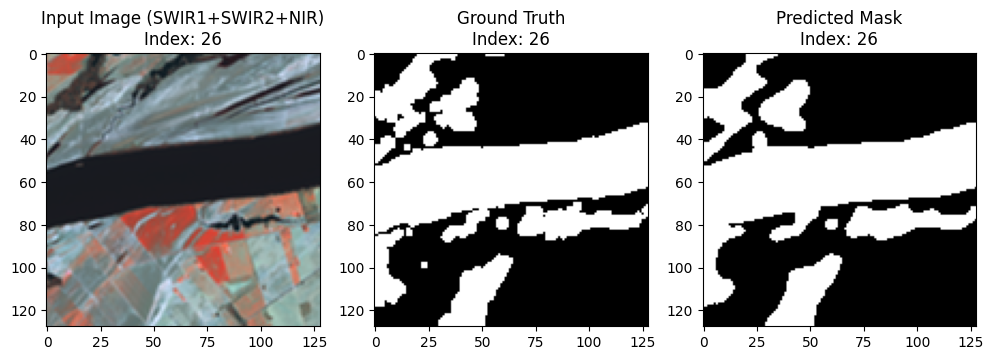

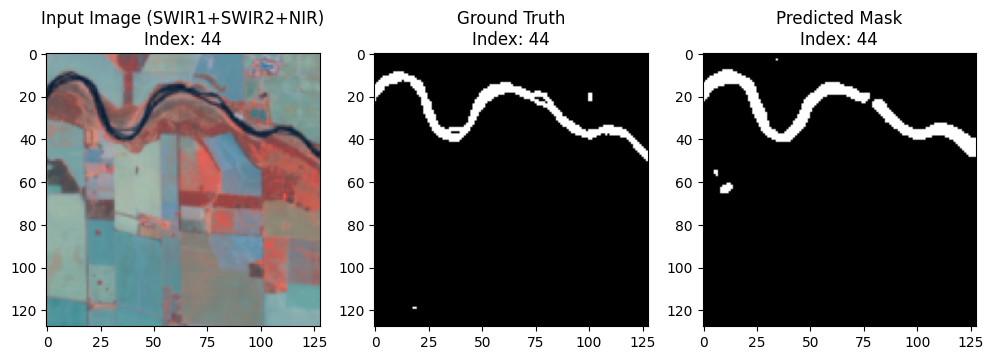

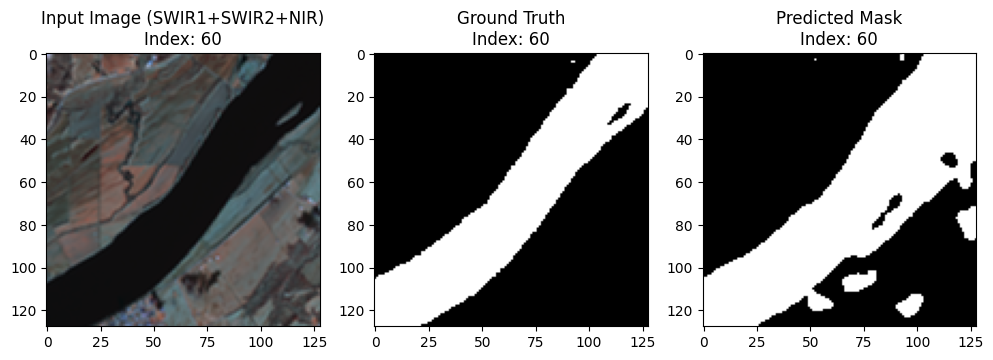

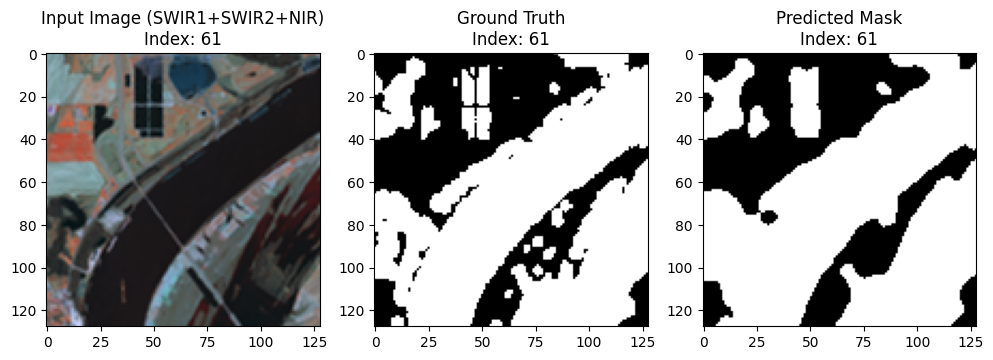

In [18]:
custom_indices = [26, 44, 60, 61]

def plot_sample(X, y_true, y_pred, idx):
    plt.figure(figsize=(12,4))

    # Input image
    plt.subplot(1,3,1)
    plt.imshow((X[idx][:,:,:3] - X[idx][:,:,:3].min()) / (X[idx][:,:,:3].max() - X[idx][:,:,:3].min()))
    plt.title(f"Input Image (SWIR1+SWIR2+NIR)\nIndex: {idx}")

    # Ground truth
    plt.subplot(1,3,2)
    plt.imshow(y_true[idx].squeeze(), cmap="gray")
    plt.title(f"Ground Truth\nIndex: {idx}")

    # Predicted mask
    plt.subplot(1,3,3)
    plt.imshow(y_pred[idx].squeeze(), cmap="gray")
    plt.title(f"Predicted Mask\nIndex: {idx}")

    plt.show()
y_pred = unet_resnet34.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

for idx in custom_indices:
    plot_sample(X_test, y_test, y_pred_bin, idx)